# Proyek Klasifikasi Gambar: Mango Leaf Disease

**Link Dataset:** https://www.kaggle.com/datasets/warcoder/mango-leaf-disease-dataset

## Import Semua Packages/Library yang Digunakan

Pertama, kita perlu mengimpor library yang dibutuhkan.

In [ ]:
# mengimpor library yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# mengimpor library untuk visualisasi gambar
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# mengimpor library untuk pengolahan data gambar
!pip install opencv-python

import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [ ]:
# mengimpor library untuk pembuatan dan evaluasi model
!pip install tensorflow

import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [ ]:
# menonaktifkan warning yang mungkin akan muncul
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Data Preparation

### Data Loading

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# mendownload kaggle dataset dan unzip file
!kaggle datasets download -d warcoder/mango-leaf-disease-dataset
!unzip mango-leaf-disease-dataset.zip

In [ ]:
# lokasi direktori dataset utama
path = '/content/MangoLeafBD Dataset'

# dictionary kosong yang akan diisi dengan daftar gambar untuk setiap kelas
gesture_images = {}

# melakukan iterasi pada seluruh folder di dalam direktori path
for class_name in os.listdir(path):
    class_dir = os.path.join(path, class_name)
    if os.path.isdir(class_dir):
        gesture_images[class_name] = os.listdir(class_dir)

fig, axs = plt.subplots(len(gesture_images.keys()), 5, figsize=(10, len(gesture_images) * 2.5))

# mengambil 5 gambar secara acak tanpa pengulangan dari setiap kelas.
for i, class_name in enumerate(sorted(gesture_images.keys())):
    images = np.random.choice(gesture_images[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set_title(class_name, fontsize=8)
        axs[i, j].axis("off")

# menghindari tumpang tindih antar plot
plt.tight_layout()

# menampilkan hasil visualisasi
plt.show()




Setiap baris menunjukkan 5 gambar acak dari 1 kelas penyakit daun mangga.

In [ ]:
# merujuk ke direktori utama dataset.
lung_path = "/content/MangoLeafBD Dataset"

# inisialisasi daftar untuk menyimpan informasi gambar
file_name = []
labels = []
full_path = []

# menelusuri semua sub-folder dan file di dalam direktori
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# membuat DataFrame distribusi data
distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# visualisasi distribusi kelas menggunakan seaborn
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

Bar chart yang menampilkan jumlah gambar untuk masing-masing kelas penyakit daun mangga dan membantu memeriksa apakah dataset seimbang atau tidak antar kelas.

### Data Preprocessing

#### Split Dataset

In [ ]:
# inisialisasi variabel dan direktori
mypath = "MangoLeafBD Dataset"
output = "datafinal"
splits = ['train', 'valid', 'test']

# menentukan rasio pembagian dataset (70% train, 15% valid, 15% test)
train_ratio, valid_ratio, test_ratio = 0.7, 0.15, 0.15

# melakukan iterasi untuk setiap kelas di dalam direktori dataset
for class_name in os.listdir(mypath):
    class_path = os.path.join(mypath, class_name)

    if os.path.isdir(class_path):

        # mendapatkan daftar gambar yang ada dalam folder kelas tertentu
        images = [image for image in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, image))]

        # membagi data menjadi dua bagian
        train_imgs, temp_imgs = train_test_split(images, test_size=1 - train_ratio, random_state=42)

        # dibagi lagi menjadi dua bagian
        valid_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        # membuat folder untuk setiap split (train, valid, dan test) dalam direktori output
        for split in ['train', 'valid', 'test']:
            split_dir = os.path.join(output, split, class_name)
            os.makedirs(split_dir, exist_ok=True)

            # memilih gambar yang disalin berdasarkan split
            if split == 'train':
                split_images = train_imgs
            elif split == 'valid':
                split_images = valid_imgs
            else:
                split_images = test_imgs

            # Menyalin gambar ke direktori yang sesuai
            for image in split_images:
                src_path = os.path.join(class_path, image)
                dst_path = os.path.join(split_dir, image)
                shutil.copy(src_path, dst_path)


## Modelling

In [ ]:
base_dir = "/content/datafinal"

# melakukan augmentasi gambar serta preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# memuat dan memproses data untuk training, validation, dan testing
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "valid"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2792 images belonging to 8 classes.
Found 600 images belonging to 8 classes.
Found 608 images belonging to 8 classes.


In [ ]:
# membuat model sequential, yang memungkinkan menambahkan lapisan berturut-turut
model = Sequential([

    # lapisan pertama
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    # lapisan kedua
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # lapisan ketiga
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # lapisan keempat
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    # mengubah hasil dari lapisan konvolusi menjadi vektor satu dimensi
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),                     # mengurangi overfitting
    Dense(8, activation='softmax')
])

# mengkompilasi model untuk mengupdate bobot model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# menampilkan ringkasan arsitektur model
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36864)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       9,437,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           2,056 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,827,912 (37.49 MB)

 Trainable params: 9,827,912 (37.49 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# menghentikan pelatihan lebih awal jika tidak ada peningkatan pada nilai val_loss selama 10 epoch berturut-turut
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# menyimpan model terbaik berdasarkan akurasi validasi (val_accuracy)
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_accuracy', mode='max')

In [ ]:
# melatih model dengan data pelatihan (train_generator) dan validasi (validation_generator)
history = model.fit(
    train_generator,
    epochs=40,
    validation_data=validation_generator,
    callbacks=[early_stop, checkpoint]     # callback untuk early stopping dan menyimpan model terbaik
)

Epoch 1/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9879 - loss: 0.0404 - val_accuracy: 0.9117 - val_loss: 0.3567
Epoch 2/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.9616 - loss: 0.1259 - val_accuracy: 0.9450 - val_loss: 0.1978
Epoch 3/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9839 - loss: 0.0515 - val_accuracy: 0.9333 - val_loss: 0.2931
Epoch 4/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9837 - loss: 0.0554 - val_accuracy: 0.9483 - val_loss: 0.2513
Epoch 5/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - accuracy: 0.9853 - loss: 0.0371 - val_accuracy: 0.9500 - val_loss: 0.1987
Epoch 6/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.9631 - loss: 0.1173 - val_accuracy: 0.9433 - val_loss: 0.1944
Epoch 7/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.9634 - loss: 0.1032 - val_accuracy: 0.9333 - val_loss: 0.2604
Epoch 8/40
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.9891 - loss: 0.0363 - val_accuracy: 0.9550 - v

## Evaluasi dan Visualisasi

In [ ]:
# engevaluasi model pada data pengujian (test set)
test_loss, test_accuracy = model.evaluate(test_generator)

# menampilkan akurasi pengujian dalam persen
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - accuracy: 0.9575 - loss: 0.2743
Test Accuracy: 95.39%


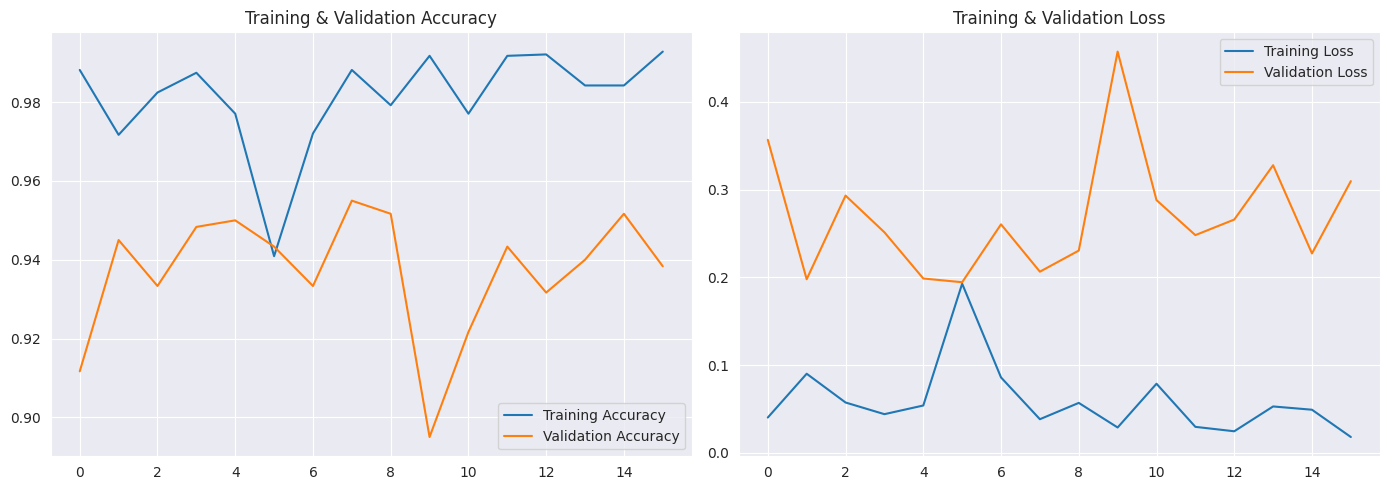

In [ ]:
# mengambil nilai akurasi dan loss dari history training
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# menentukan rentang epoch untuk sumbu X
epochs_range = range(len(acc))

# membuat figure dengan ukuran 14x5
plt.figure(figsize=(14, 5))

# plot akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend(loc='lower right')

# plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


## Konversi Model

**Menyimpan model ke dalam format TensorFlow SavedModel**

In [ ]:
model.export("saved_model/")

**Konversi model TensorFlow ke format TensorFlow Lite (TFLite)**

In [ ]:
# membuat folder tflite/ jika belum ada, untuk menyimpan file .tflite.
os.makedirs("tflite", exist_ok=True)

# membuat converter untuk mengonversi model yang telah disimpan dalam format SavedModel
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model/")

# mengonversi model menjadi format TensorFlow Lite
tflite_model = converter.convert()

# menyimpan hasil konversi ke file model.tflite
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

**Konversi model ke TensorFlow.js**

In [ ]:
!pip install tensorflowjs
!tensorflowjs_converter --input_format=tf_saved_model --output_node_names='output_node_name' --saved_model_tags=serve saved_model/ tfjs_model/


## Inference (Optional)

Prediction Results:: anthracnose (99.44%)


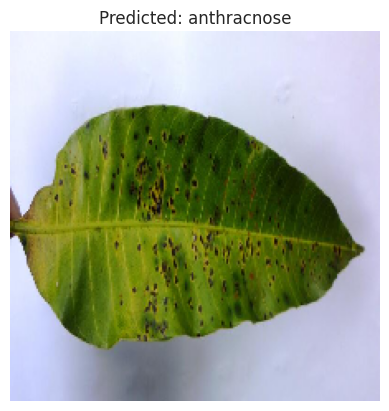

In [ ]:
# daftar label sesuai urutan klasifikasi yang digunakan saat pelatihan
class_names = [
    'anthracnose',
    'bacterial canker',
    'cutting weevil',
    'die back',
    'gall midge',
    'healthy',
    'powdery mildew',
    'sooty mould'
]

# memuat model dari folder saved_model/
model = tf.saved_model.load('saved_model')

# load dan preprocess gambar uji
img_path = 'mangoleaf.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# mengambil fungsi untuk melakukan prediksi (inferensi) dari model.
infer = model.signatures['serving_default']
pred = infer(tf.convert_to_tensor(img_array))

# mengambil key output dan hasil prediksi
output_key = list(pred.keys())[0]
output_data = pred[output_key].numpy()

#  mengambil indeks dengan nilai probabilitas tertinggi dan mencocokkannya ke label serta mengambil nilai confidence-nya.
predicted_index = np.argmax(output_data)
predicted_label = class_names[predicted_index]
confidence = output_data[0][predicted_index]

# menampilkan hasil prediksi ke layar.
print(f"Prediction Results:: {predicted_label} ({confidence*100:.2f}%)")

# menampilkan gambar beserta label hasil prediksi sebagai judul
plt.imshow(img)
plt.title(f"Predicted: {predicted_label}")
plt.axis('off')
plt.show()